# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
import json
import os
import sys
import glob
from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
import numpy
import pickle
import matplotlib.pyplot as plt

import jax
from jax import jit
from noisyopt import minimizeSPSA, minimizeCompass

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from discopy.utils import loads
#from pytket.extensions.qiskit import AerBackend
#from pytket.extensions.qulacs import QulacsBackend
#from pytket.extensions.cirq import CirqStateSampleBackend
backend = None

from utils import *
#from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')
this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np

rng = numpy.random.default_rng(SEED)
numpy.random.seed(SEED)

## Read circuit data

We read the circuits from the pickled files. Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
#workload = "execution_time"
workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 2
layers = 1
single_qubit_params = 3
n_wire_count = 1

loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification, workload)
test_data_labels = create_labeled_classes(test_data, classification, workload)
validation_data_labels = create_labeled_classes(validation_data, classification, workload)

## Lambeq optimizer

## Model

In [5]:
def make_pred_fn(circuits):
    # In the case we want to use other backends. 
    # Currently does not work properly.
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

## Loss function and evaluation

In [6]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Minimization with noisyopt

In [7]:
def initialize_parameters(old_params, old_values, new_params):
    new_values = list(numpy.array(rng.random(len(new_params))))
    old_param_dict = {}
    for p, v in zip(old_params, old_values):
        old_param_dict[p] = v
        
    parameters = sorted(set(old_params + new_params), key=default_sort_key)
    values = []
    for p in parameters:
        if p in old_param_dict:
            values.append(old_param_dict[p])
        else:
            values.append(new_values.pop())
            
    return parameters, np.array(values)

In [8]:
EPOCHS = 4000
initial_number_of_circuits = 192
syms = {}
limit = False
all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:initial_number_of_circuits + 1]
current_training_circuits = {}
result_file = workload + "_" + workload_size + "_noisyopt_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params)

for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]
    
syms = get_symbols(current_training_circuits)
parameters = sorted(syms, key=default_sort_key)
if initial_number_of_circuits > 5 and os.path.exists("points//" + result_file + ".npz"):
    with open("points//" + result_file + ".npz", "rb") as f:
        print("Loading parameters from file " + result_file)
        npzfile = np.load(f)
        init_params_spsa = npzfile['arr_0']
else:
    print("Initializing new parameters")
    init_params_spsa = np.array(rng.random(len(parameters)))
result = None
run = 0

Loading parameters from file execution_time_main_noisyopt_2_1_3


Progress:  0.868


Number of training circuits: 384   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 09:27:21.418780: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 09:35:16.685128: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 9m55.266313397s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3338   valid/loss: 0.4564   train/acc: 0.888   valid/acc: 0.8056
Epoch: 400   train/loss: 0.3471   valid/loss: 0.4554   train/acc: 0.8724   valid/acc: 0.8056
Epoch: 600   train/loss: 0.3525   valid/loss: 0.4558   train/acc: 0.8854   valid/acc: 0.7963
Epoch: 800   train/los

Test accuracy: 0.8165138
Progress:  0.871
Number of training circuits: 385   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 10:11:04.392735: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m10.768278149s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.347   valid/loss: 0.4593   train/acc: 0.8753   valid/acc: 0.8148
Epoch: 400   train/loss: 0.3361   valid/loss: 0.4593   train/acc: 0.8805   valid/acc: 0.8148
Epoch: 600   train/loss: 0.3351   valid/loss: 0.4593   train/acc: 0.8753   valid/acc: 0.8148
Epoch: 800   train/loss: 0.3329   valid/loss: 0.4593   train/acc: 0.8805   valid/acc: 0.8148
Epoch: 1000   train/loss: 0.3326   valid/loss: 0.4587   train/acc: 0.8857   valid/acc: 0.8148
Epoch: 1200   train/loss: 0.3286   valid/loss: 0.4588   train/acc: 0.8883   valid/acc: 0.8148
Epoch: 1400   train/loss: 0.3398   valid/loss: 0.4586   train/acc: 0.880

Test accuracy: 0.8165138
Progress:  0.873
Number of training circuits: 386   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 10:47:11.009271: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m19.706146219s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.334   valid/loss: 0.4596   train/acc: 0.8782   valid/acc: 0.8148
Epoch: 400   train/loss: 0.3233   valid/loss: 0.4584   train/acc: 0.886   valid/acc: 0.8148
Epoch: 600   train/loss: 0.3382   valid/loss: 0.4588   train/acc: 0.8808   valid/acc: 0.8148
Epoch: 800   train/loss: 0.3273   valid/loss: 0.4589   train/acc: 0.8756   valid/acc: 0.8148
Epoch: 1000   train/loss: 0.3442   valid/loss: 0.4589   train/acc: 0.8782   valid/acc: 0.8148
Epoch: 1200   train/loss: 0.3268   valid/loss: 0.4591   train/acc: 0.8808   valid/acc: 0.8148
Epoch: 1400   train/loss: 0.3402   valid/loss: 0.4598   train/acc: 0.8834

Test accuracy: 0.8165138
Progress:  0.875
Number of training circuits: 387   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 11:15:10.037680: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 11:23:35.412743: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m25.375045238s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3679   valid/loss: 0.4613   train/acc: 0.876   valid/acc: 0.8148
Epoch: 400   train/loss: 0.3406   valid/loss: 0.4601   train/acc: 0.8889   valid/acc: 0.8148
Epoch: 600   train/loss: 0.3243   valid/loss: 0.4593   train/acc: 0.8915   valid/acc: 0.8148
Epoch: 800   train/lo

Test accuracy: 0.8165138
Progress:  0.877
Number of training circuits: 388   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 12:00:16.691456: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m33.95779336s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3309   valid/loss: 0.4574   train/acc: 0.8789   valid/acc: 0.8056
Epoch: 400   train/loss: 0.3609   valid/loss: 0.4578   train/acc: 0.8686   valid/acc: 0.8148
Epoch: 600   train/loss: 0.3337   valid/loss: 0.4561   train/acc: 0.8737   valid/acc: 0.8148
Epoch: 800   train/loss: 0.3296   valid/loss: 0.4565   train/acc: 0.8892   valid/acc: 0.8148
Epoch: 1000   train/loss: 0.3432   valid/loss: 0.4558   train/acc: 0.884   valid/acc: 0.8148
Epoch: 1200   train/loss: 0.3378   valid/loss: 0.4559   train/acc: 0.8866   valid/acc: 0.8148
Epoch: 1400   train/loss: 0.3523   valid/loss: 0.4559   train/acc: 0.8763

Test accuracy: 0.8165138
Progress:  0.879
Number of training circuits: 389   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 12:28:28.371499: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 12:37:01.246282: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m32.874748806s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3741   valid/loss: 0.4555   train/acc: 0.8509   valid/acc: 0.8148
Epoch: 400   train/loss: 0.3442   valid/loss: 0.4573   train/acc: 0.8843   valid/acc: 0.8148
Epoch: 600   train/loss: 0.3304   valid/loss: 0.4579   train/acc: 0.8869   valid/acc: 0.8148
Epoch: 800   train/l

Test accuracy: 0.8165138
Progress:  0.882
Number of training circuits: 390   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 13:05:19.651284: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 13:13:55.309516: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m35.65820931s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3391   valid/loss: 0.4541   train/acc: 0.8641   valid/acc: 0.8148
Epoch: 400   train/loss: 0.3294   valid/loss: 0.4539   train/acc: 0.8795   valid/acc: 0.8148
Epoch: 600   train/loss: 0.3425   valid/loss: 0.4525   train/acc: 0.8795   valid/acc: 0.8148
Epoch: 800   train/lo

Test accuracy: 0.8165138
Progress:  0.884
Number of training circuits: 391   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 13:42:22.940786: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 13:51:02.133647: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m39.192885156s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.322   valid/loss: 0.4598   train/acc: 0.8772   valid/acc: 0.8148
Epoch: 400   train/loss: 0.3304   valid/loss: 0.4585   train/acc: 0.89   valid/acc: 0.8148
Epoch: 600   train/loss: 0.3318   valid/loss: 0.4571   train/acc: 0.89   valid/acc: 0.8241
Epoch: 800   train/loss: 

Test accuracy: 0.8165138
Progress:  0.886
Number of training circuits: 392   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 14:28:18.106685: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m41.938412941s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.339   valid/loss: 0.4538   train/acc: 0.8776   valid/acc: 0.8148
Epoch: 400   train/loss: 0.3482   valid/loss: 0.4536   train/acc: 0.8418   valid/acc: 0.8241
Epoch: 600   train/loss: 0.3333   valid/loss: 0.4546   train/acc: 0.8827   valid/acc: 0.8241
Epoch: 800   train/loss: 0.3471   valid/loss: 0.4538   train/acc: 0.8699   valid/acc: 0.8241
Epoch: 1000   train/loss: 0.3252   valid/loss: 0.455   train/acc: 0.8852   valid/acc: 0.8241
Epoch: 1200   train/loss: 0.3249   valid/loss: 0.4549   train/acc: 0.8827   valid/acc: 0.8241
Epoch: 1400   train/loss: 0.3438   valid/loss: 0.4556   train/acc: 0.8801

Test accuracy: 0.8165138
Progress:  0.888
Number of training circuits: 393   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 14:56:53.398787: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 15:05:39.690720: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m46.292024339s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3356   valid/loss: 0.4526   train/acc: 0.8855   valid/acc: 0.8241
Epoch: 400   train/loss: 0.3508   valid/loss: 0.4529   train/acc: 0.8626   valid/acc: 0.8241
Epoch: 600   train/loss: 0.3578   valid/loss: 0.4539   train/acc: 0.8677   valid/acc: 0.8241
Epoch: 800   train/l

Test accuracy: 0.8165138
Progress:  0.891
Number of training circuits: 394   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 15:34:22.695867: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 15:43:23.192566: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m0.496655691s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3433   valid/loss: 0.4487   train/acc: 0.8782   valid/acc: 0.8241
Epoch: 400   train/loss: 0.3392   valid/loss: 0.4497   train/acc: 0.8731   valid/acc: 0.8241
Epoch: 600   train/loss: 0.3343   valid/loss: 0.451   train/acc: 0.8858   valid/acc: 0.8148
Epoch: 800   train/los

Test accuracy: 0.8165138
Progress:  0.893
Number of training circuits: 395   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 16:12:27.614668: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 16:21:35.813453: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m8.198775531s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3369   valid/loss: 0.4509   train/acc: 0.8734   valid/acc: 0.8241
Epoch: 400   train/loss: 0.3472   valid/loss: 0.4527   train/acc: 0.8759   valid/acc: 0.8241
Epoch: 600   train/loss: 0.3442   valid/loss: 0.4537   train/acc: 0.8835   valid/acc: 0.8241
Epoch: 800   train/lo

Test accuracy: 0.8165138
Progress:  0.895
Number of training circuits: 396   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 16:50:32.260435: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 16:59:44.880073: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m12.619585001s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3451   valid/loss: 0.4535   train/acc: 0.8687   valid/acc: 0.8241
Epoch: 400   train/loss: 0.3375   valid/loss: 0.4541   train/acc: 0.8813   valid/acc: 0.8241
Epoch: 600   train/loss: 0.3429   valid/loss: 0.4536   train/acc: 0.8763   valid/acc: 0.8241
Epoch: 800   train/l

Test accuracy: 0.82568806
Progress:  0.897
Number of training circuits: 397   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 17:28:42.964851: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 17:37:54.346182: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m11.381419157s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3486   valid/loss: 0.455   train/acc: 0.8615   valid/acc: 0.8241
Epoch: 400   train/loss: 0.3467   valid/loss: 0.4547   train/acc: 0.869   valid/acc: 0.8241
Epoch: 600   train/loss: 0.3408   valid/loss: 0.4552   train/acc: 0.8766   valid/acc: 0.8241
Epoch: 800   train/los

Test accuracy: 0.82568806
Progress:  0.9
Number of training circuits: 398   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 18:07:01.325043: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 18:16:32.118699: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m30.79357676s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3632   valid/loss: 0.4511   train/acc: 0.8593   valid/acc: 0.8241
Epoch: 400   train/loss: 0.3493   valid/loss: 0.4526   train/acc: 0.8869   valid/acc: 0.8241
Epoch: 600   train/loss: 0.3279   valid/loss: 0.4522   train/acc: 0.892   valid/acc: 0.8241
Epoch: 800   train/los

Test accuracy: 0.82568806
Progress:  0.902
Number of training circuits: 399   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 18:45:47.993200: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 18:55:20.351555: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m32.358373824s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.339   valid/loss: 0.4495   train/acc: 0.8872   valid/acc: 0.8056
Epoch: 400   train/loss: 0.3493   valid/loss: 0.4507   train/acc: 0.8647   valid/acc: 0.8148
Epoch: 600   train/loss: 0.3372   valid/loss: 0.4508   train/acc: 0.8797   valid/acc: 0.8148
Epoch: 800   train/lo

Test accuracy: 0.82568806
Progress:  0.904
Number of training circuits: 400   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 19:34:14.059583: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m41.003748298s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3343   valid/loss: 0.4521   train/acc: 0.8875   valid/acc: 0.8056
Epoch: 400   train/loss: 0.3481   valid/loss: 0.4544   train/acc: 0.8675   valid/acc: 0.8056
Epoch: 600   train/loss: 0.3465   valid/loss: 0.4557   train/acc: 0.87   valid/acc: 0.8056
Epoch: 800   train/loss: 0.3274   valid/loss: 0.4564   train/acc: 0.8875   valid/acc: 0.8056
Epoch: 1000   train/loss: 0.3221   valid/loss: 0.457   train/acc: 0.875   valid/acc: 0.8056
Epoch: 1200   train/loss: 0.335   valid/loss: 0.4571   train/acc: 0.8775   valid/acc: 0.8056
Epoch: 1400   train/loss: 0.3588   valid/loss: 0.4567   train/acc: 0.8575   

Test accuracy: 0.82568806
Progress:  0.906
Number of training circuits: 401   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 20:03:37.130778: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 20:13:14.657045: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m37.526261193s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 0.3302   valid/loss: 0.4542   train/acc: 0.8778   valid/acc: 0.8056
Epoch: 400   train/loss: 0.3559   valid/loss: 0.4532   train/acc: 0.8628   valid/acc: 0.8056
Epoch: 600   train/loss: 0.3353   valid/loss: 0.4531   train/acc: 0.8678   valid/acc: 0.8056
Epoch: 800   train/l

Test accuracy: 0.82568806
Progress:  0.908
Number of training circuits: 402   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 20:42:43.130399: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 20:52:20.201363: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m37.071025639s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 20:59:01.573467: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.911
Number of training circuits: 403   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 21:21:56.690702: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 21:31:44.203567: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m47.512779868s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 21:38:30.163924: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.913
Number of training circuits: 404   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 22:01:24.972354: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 22:11:14.726790: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m49.754429666s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 22:17:58.966328: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.915
Number of training circuits: 405   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 22:41:06.550842: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 22:51:05.474728: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m58.923845928s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 22:57:48.711584: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.917
Number of training circuits: 406   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-05 23:20:58.765769: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 23:31:01.075097: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m2.30932659s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-05 23:37:48.072625: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
**

Test accuracy: 0.82568806
Progress:  0.92
Number of training circuits: 407   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 00:00:58.397760: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 00:10:52.309602: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m53.911782009s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 00:17:42.510070: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.922
Number of training circuits: 408   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 00:41:00.972171: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 00:51:00.477890: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m59.505636161s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 00:57:41.809970: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.924
Number of training circuits: 409   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 01:31:11.260154: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m1.904252661s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 01:37:53.838674: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 01:37:58.594060: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m4.755033765s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to

Test accuracy: 0.82568806
Progress:  0.926
Number of training circuits: 410   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 02:01:28.150531: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 02:11:41.583750: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m13.433112265s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 02:18:25.618229: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.929
Number of training circuits: 411   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 02:42:08.592515: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 02:52:18.298697: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m9.706094286s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 02:59:01.621412: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Test accuracy: 0.82568806
Progress:  0.931
Number of training circuits: 412   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 03:22:41.521003: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 03:32:44.251314: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m2.730377345s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 03:39:30.829774: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Test accuracy: 0.82568806
Progress:  0.933
Number of training circuits: 413   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 04:03:24.067453: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 04:13:41.543675: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m17.476298724s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 04:20:27.532326: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.935
Number of training circuits: 413   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 04:44:22.650384: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 04:54:40.885357: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m18.234825482s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 05:01:28.259533: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.938
Number of training circuits: 414   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 05:25:21.766032: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 05:35:48.407588: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m26.641597988s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 05:42:40.989071: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.94
Number of training circuits: 415   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 06:06:38.188377: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 06:16:59.920947: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m21.732586975s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 06:23:47.251814: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.942
Number of training circuits: 416   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 06:47:52.754098: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 06:58:23.121055: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m30.36677103s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 07:05:11.908223: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Test accuracy: 0.82568806
Progress:  0.944
Number of training circuits: 417   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 07:29:25.122490: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 07:40:12.194662: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m47.072782958s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 07:47:10.842752: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.946
Number of training circuits: 418   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 08:11:50.106201: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 08:22:34.904900: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m44.79841057s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 08:29:28.143502: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Test accuracy: 0.82568806
Progress:  0.949
Number of training circuits: 419   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 08:53:55.959163: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 09:04:44.680846: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m48.721910951s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 09:11:38.005980: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.951
Number of training circuits: 420   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 09:36:21.369668: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 09:47:02.009268: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m40.64041971s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 09:54:04.707951: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Test accuracy: 0.82568806
Progress:  0.953
Number of training circuits: 421   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 10:18:54.935333: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 10:29:40.984587: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m46.049079652s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 10:36:38.977667: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.955
Number of training circuits: 422   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 11:01:25.280360: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 11:12:13.681382: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m48.402679107s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 11:19:24.732364: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.958
Number of training circuits: 423   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 11:44:26.698506: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 11:55:15.591229: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m48.894187585s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 12:02:23.159517: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.96
Number of training circuits: 424   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 12:38:37.780405: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m55.394003487s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 12:45:51.410578: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 12:46:01.501163: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m10.090215712s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_

Test accuracy: 0.82568806
Progress:  0.962
Number of training circuits: 425   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 13:11:25.805353: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 13:22:21.064062: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m55.260051037s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 13:29:52.310664: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.964
Number of training circuits: 426   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 13:55:51.752407: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 14:06:50.476936: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m58.726366827s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 14:14:30.386815: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.967
Number of training circuits: 427   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 14:40:39.693630: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 14:51:56.553949: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m16.860402721s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 14:59:44.535155: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.8165138
Progress:  0.969
Number of training circuits: 428   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 15:26:48.655512: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 15:38:07.479153: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m18.825216122s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 15:46:13.277308: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.80733943
Progress:  0.971
Number of training circuits: 429   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 16:13:19.463077: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 16:24:33.264322: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m13.802673608s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 16:32:43.372560: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.973
Number of training circuits: 430   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 17:00:33.344291: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 17:11:51.374633: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m18.031344007s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 17:20:20.419341: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.8165138
Progress:  0.975
Number of training circuits: 431   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 17:48:29.275995: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 17:59:55.098101: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m25.821841584s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 18:08:22.673320: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.8165138
Progress:  0.978
Number of training circuits: 431   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 18:37:06.251152: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 18:48:25.518099: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m19.267289166s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 18:57:19.158785: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.8165138
Progress:  0.98
Number of training circuits: 432   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 19:26:37.404562: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 19:38:00.874266: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m23.471222823s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 19:46:57.508636: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.80733943
Progress:  0.982
Number of training circuits: 433   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 20:16:36.506428: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 20:28:02.619875: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m26.115617143s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 20:37:10.602550: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.80733943
Progress:  0.984
Number of training circuits: 434   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 21:07:44.187552: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 21:19:12.357688: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m28.171218374s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 21:28:37.198690: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.8165138
Progress:  0.987
Number of training circuits: 435   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 22:00:07.060286: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 22:11:32.616057: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m25.556262215s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 22:21:19.057867: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.8165138
Progress:  0.989
Number of training circuits: 436   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 22:54:43.367530: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 23:06:09.883101: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m26.517429135s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-06 23:16:14.490920: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.8348624
Progress:  0.991
Number of training circuits: 437   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-06 23:52:09.378266: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-07 00:03:42.693453: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m33.317684091s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-07 00:14:13.144296: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.993
Number of training circuits: 438   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-07 00:54:19.676269: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-07 01:05:53.834156: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m34.159536601s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-07 01:17:01.006337: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.996
Number of training circuits: 439   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-07 01:59:39.069891: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-07 02:11:02.729531: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m23.661590648s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-07 02:22:10.719007: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.82568806
Progress:  0.998
Number of training circuits: 440   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 283


2022-12-07 03:11:47.874855: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-07 03:23:13.341994: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m25.469791638s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-07 03:34:59.333538: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.8165138


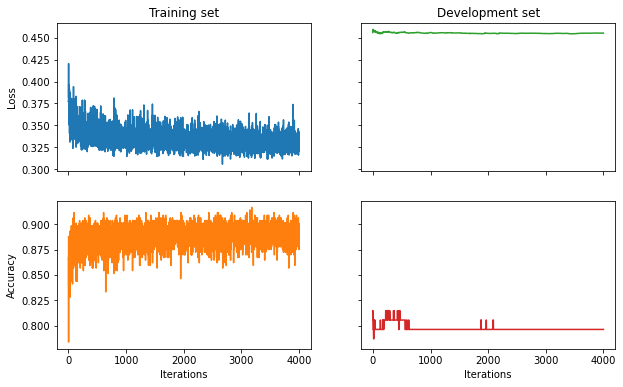

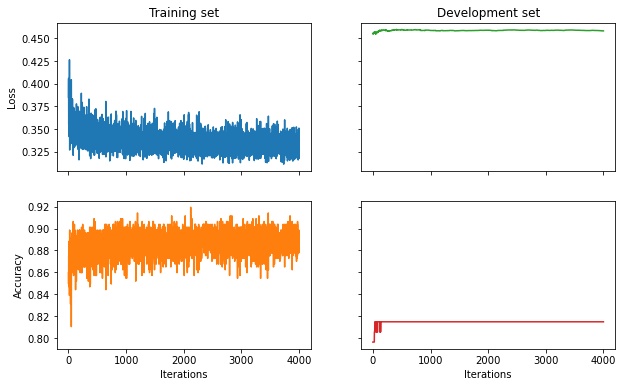

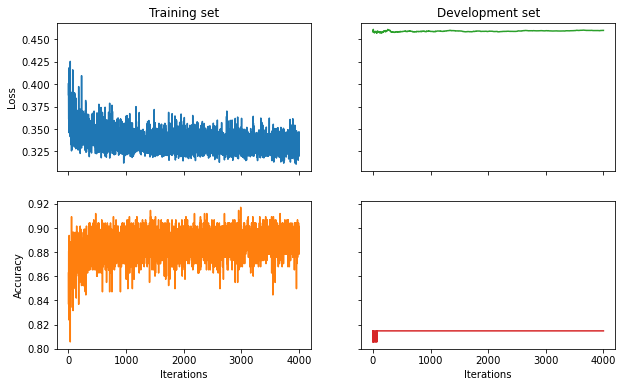

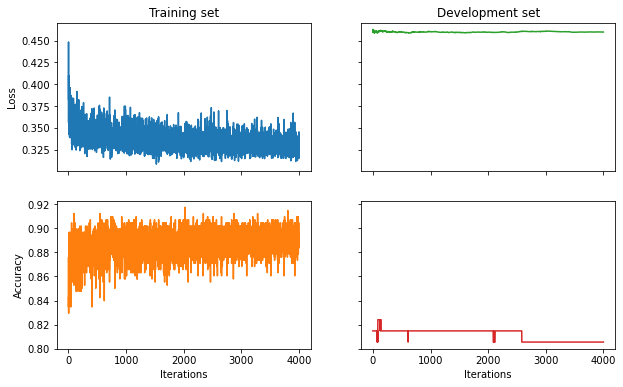

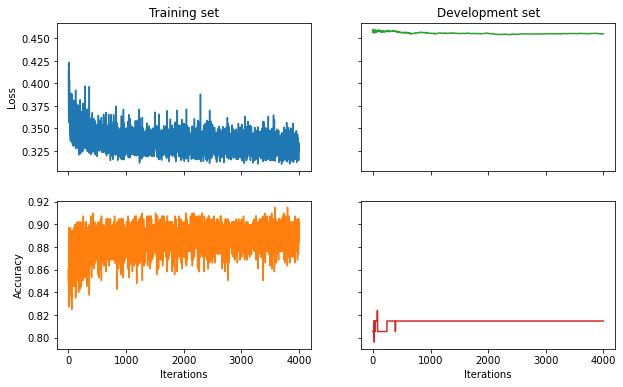

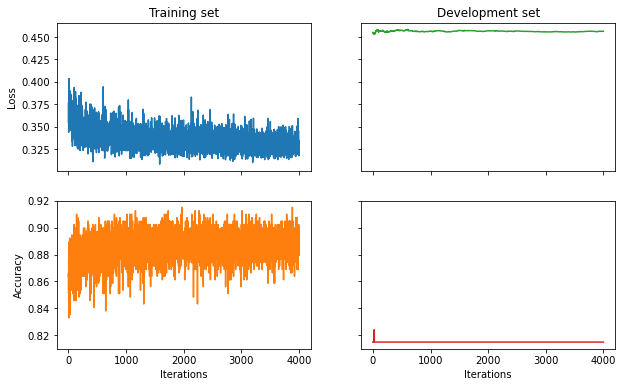

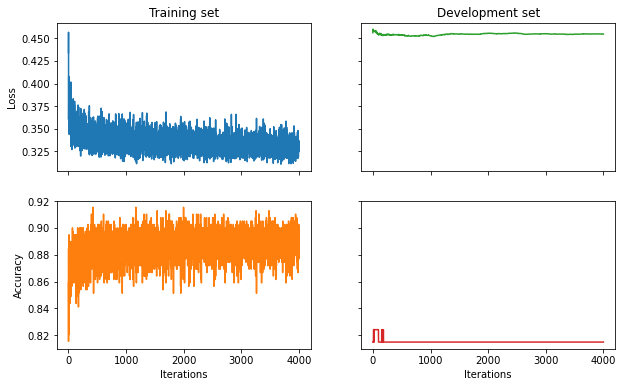

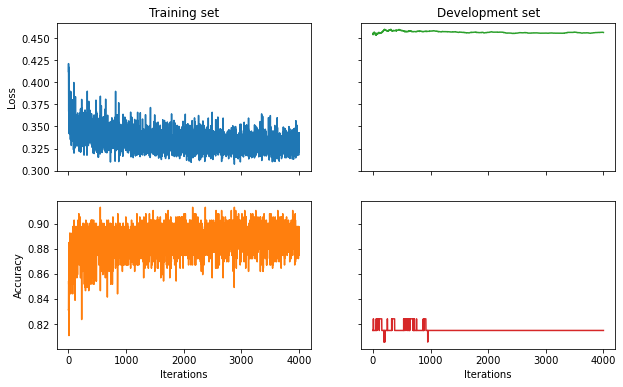

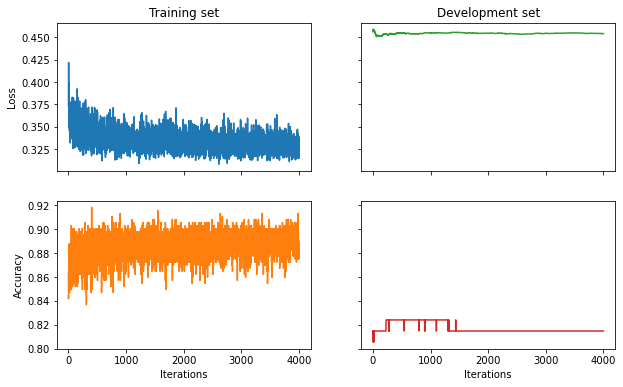

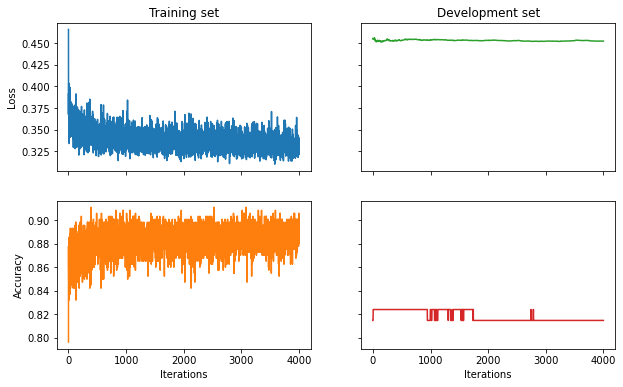

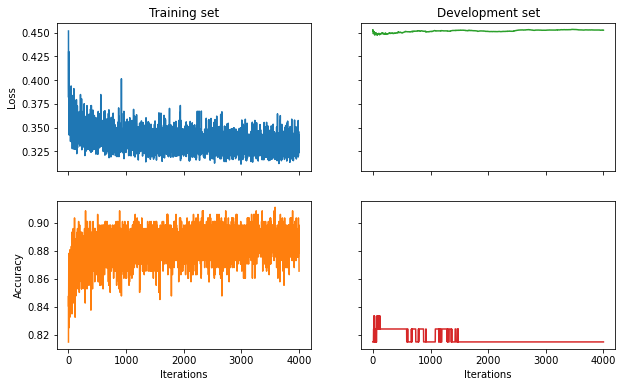

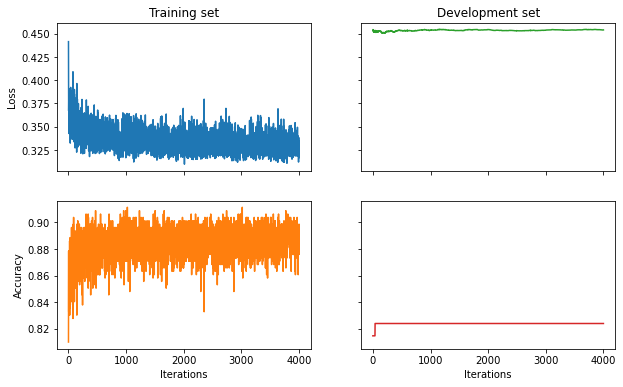

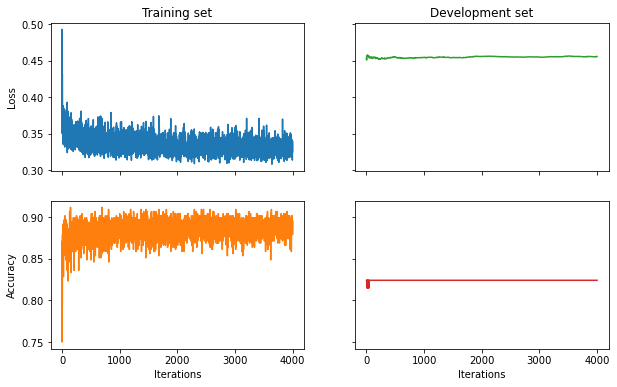

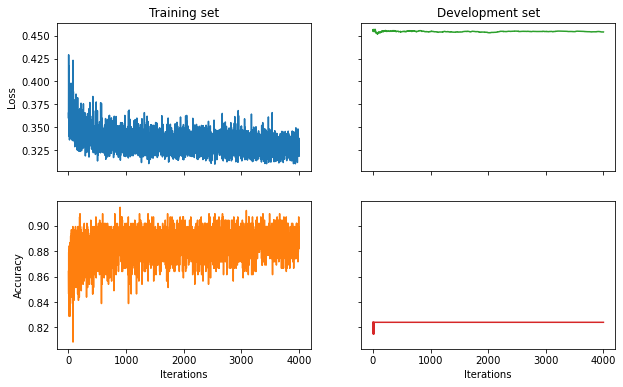

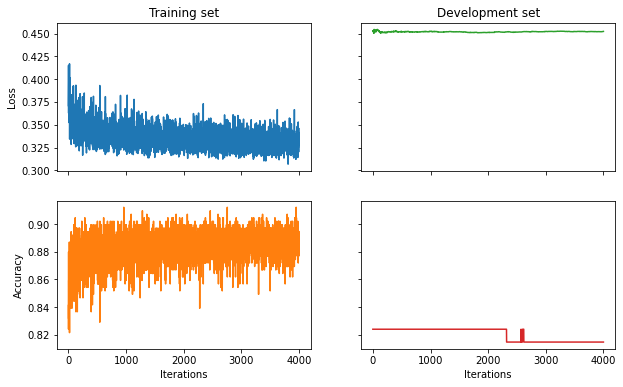

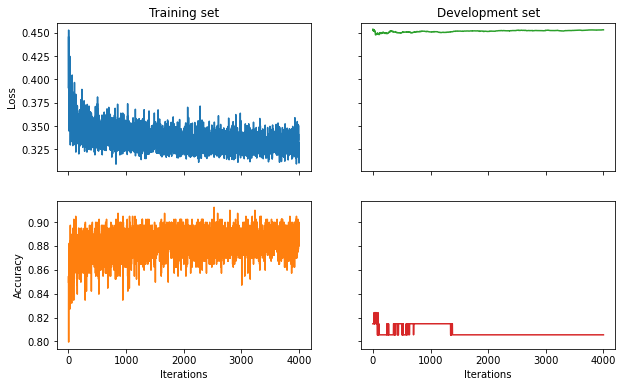

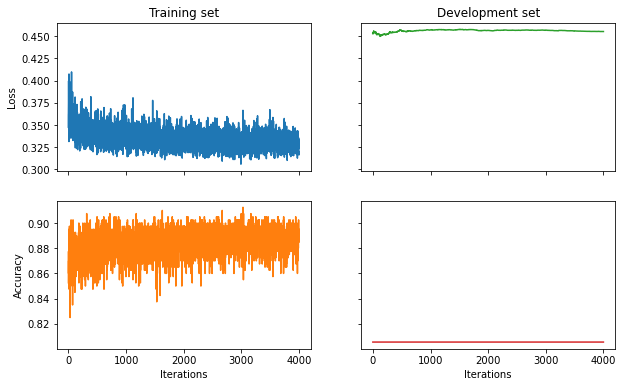

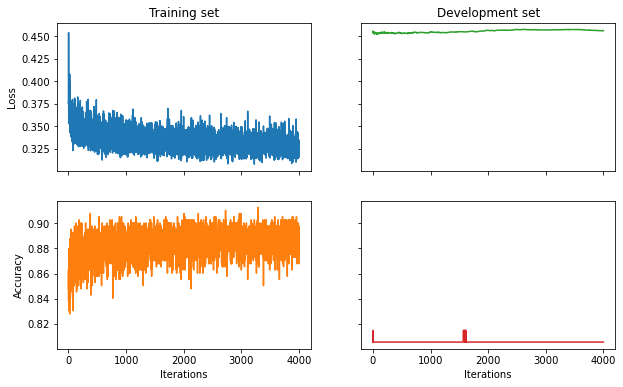

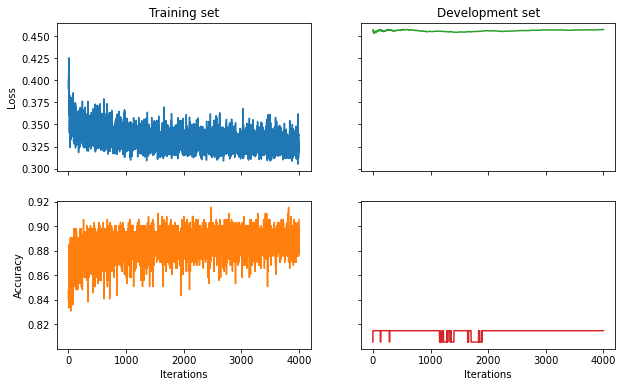

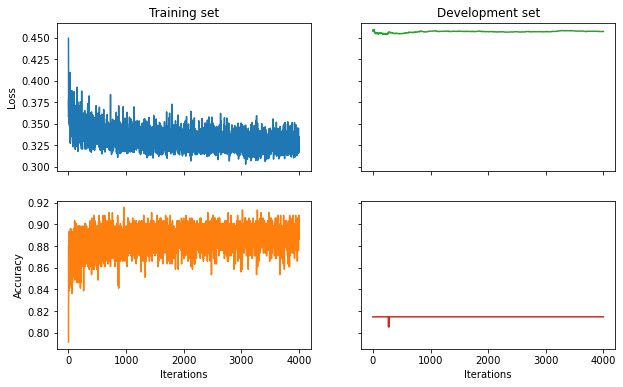

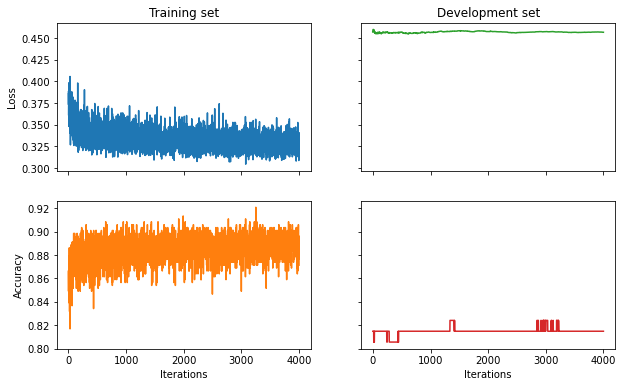

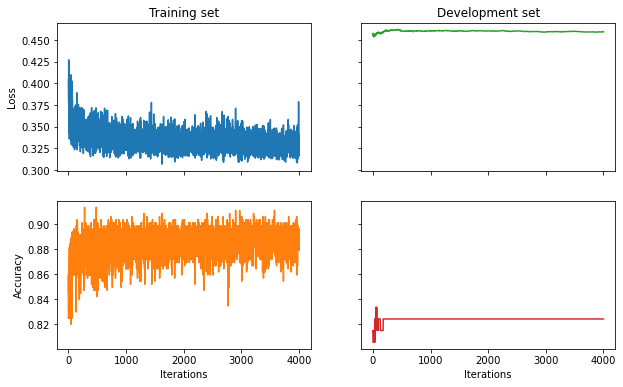

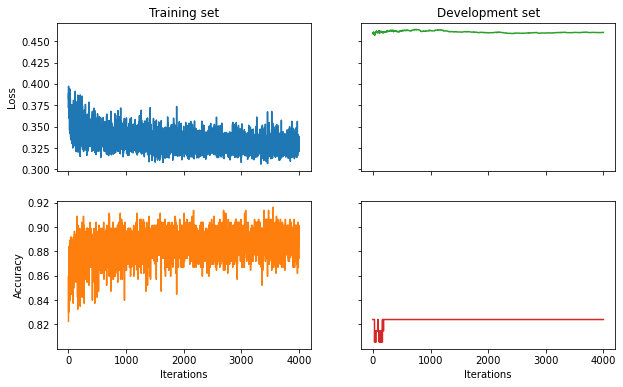

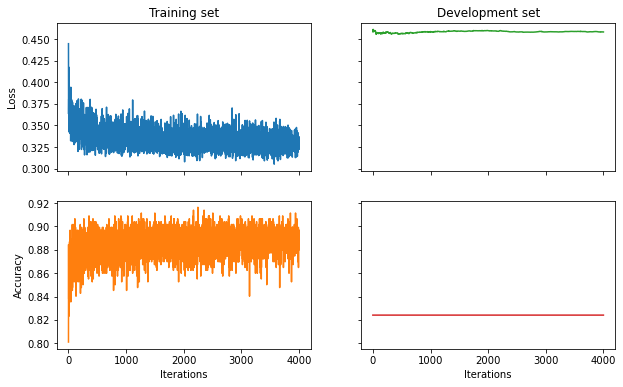

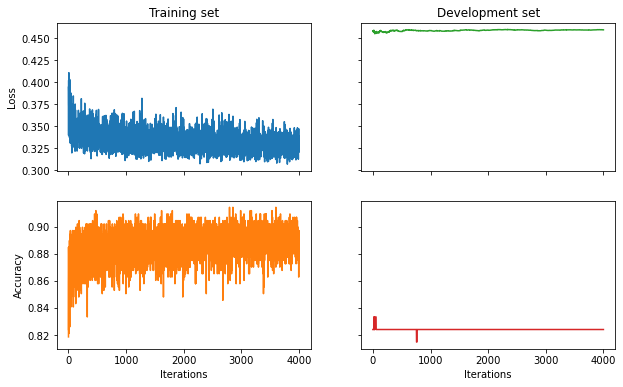

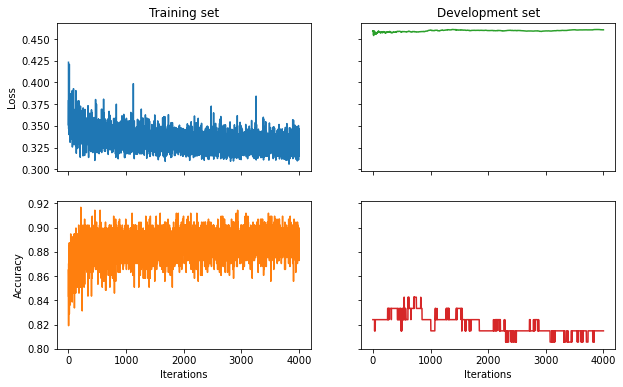

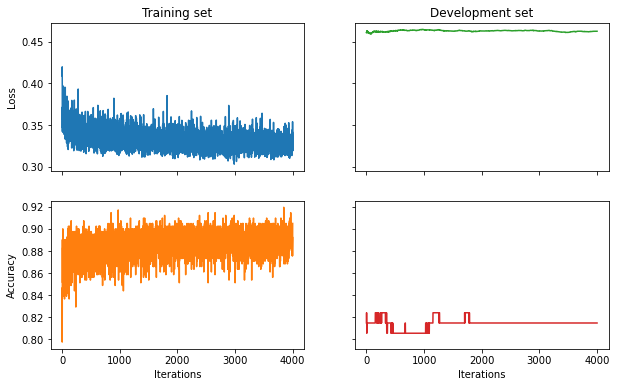

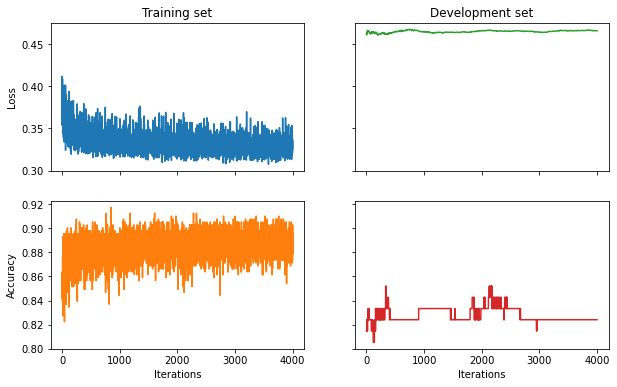

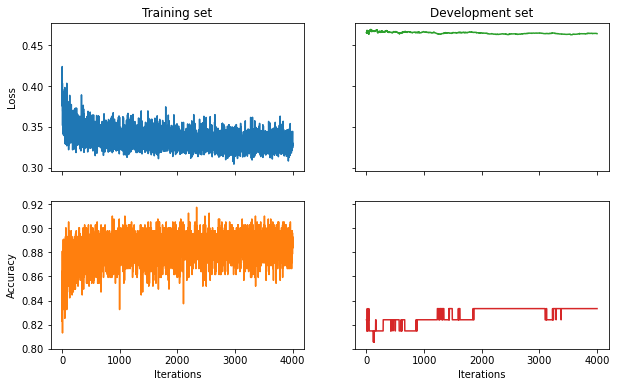

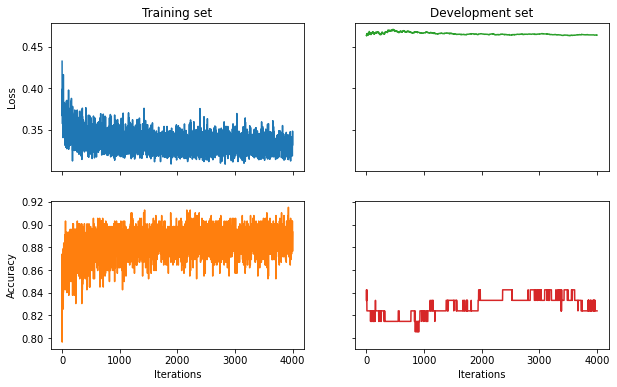

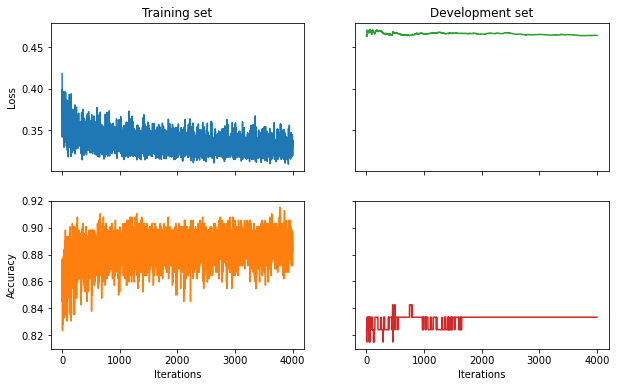

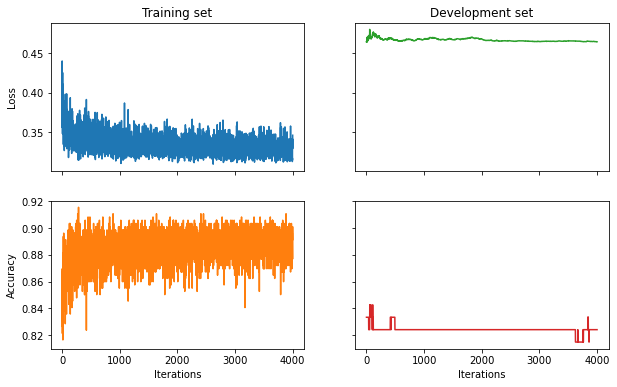

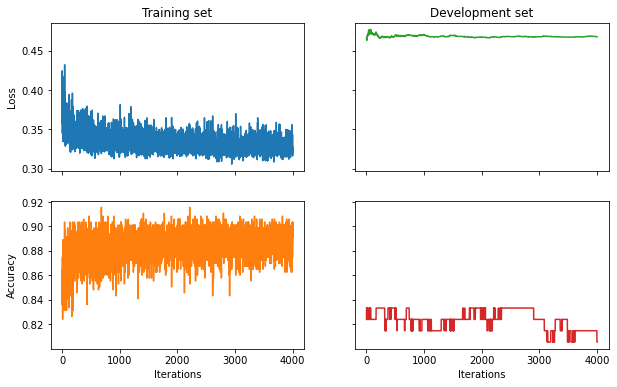

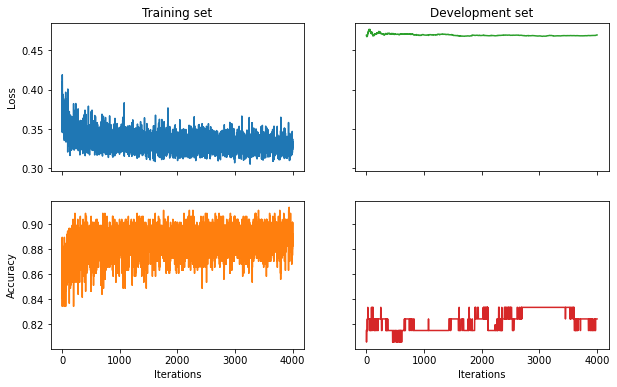

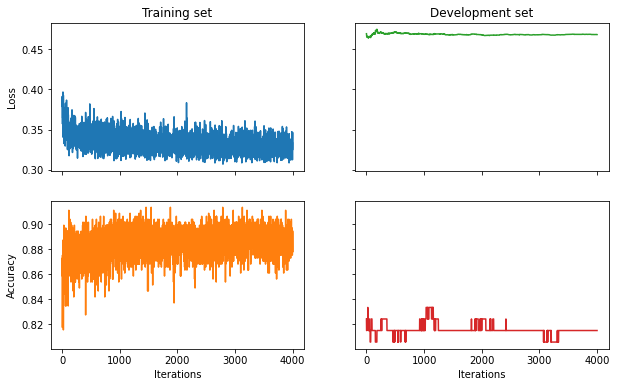

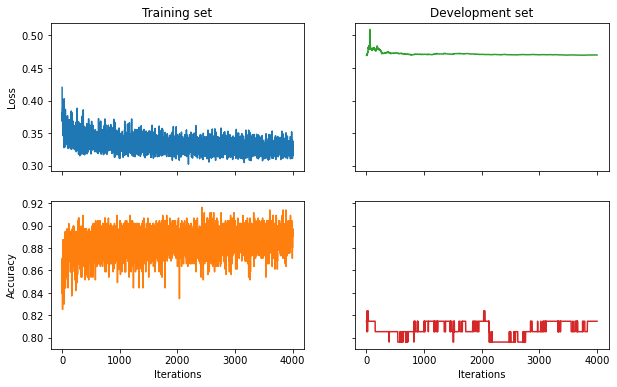

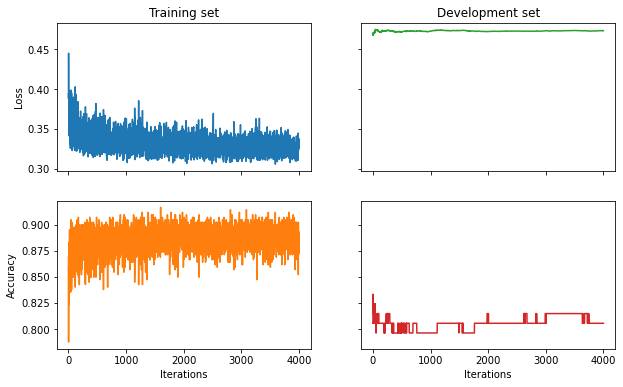

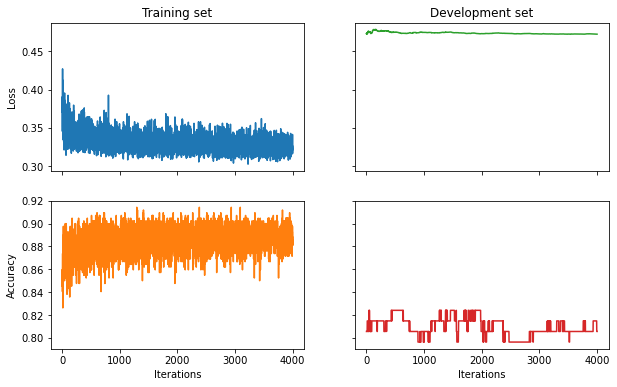

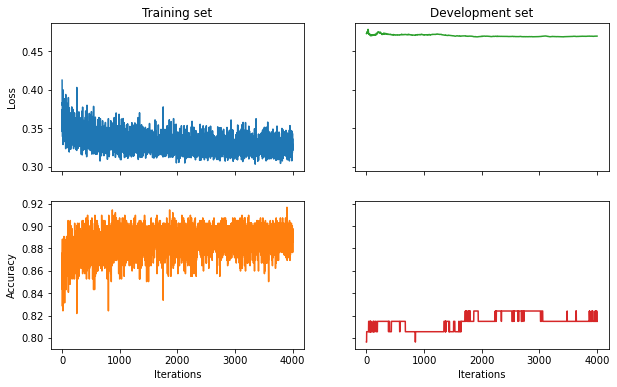

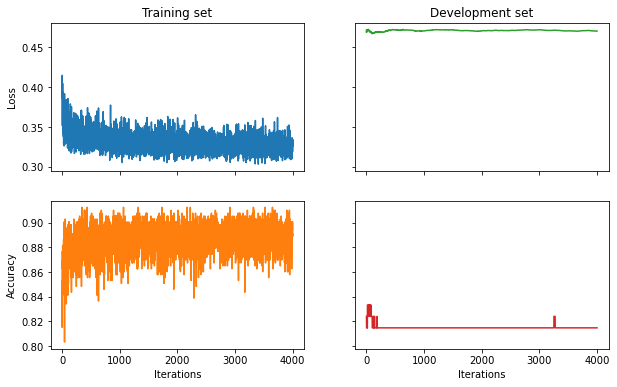

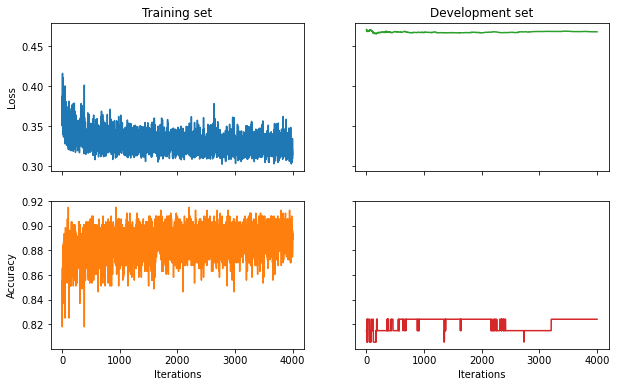

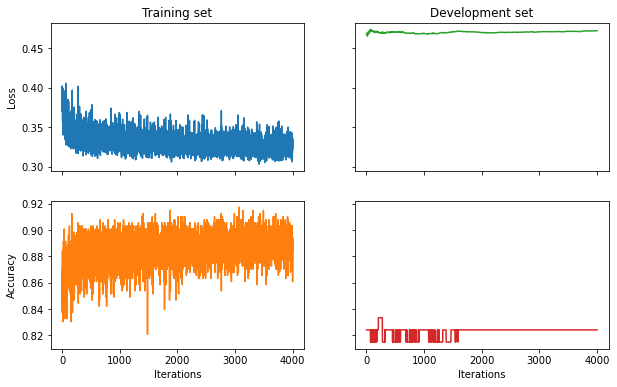

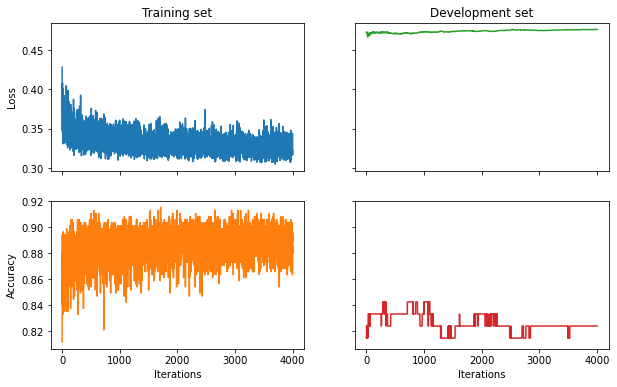

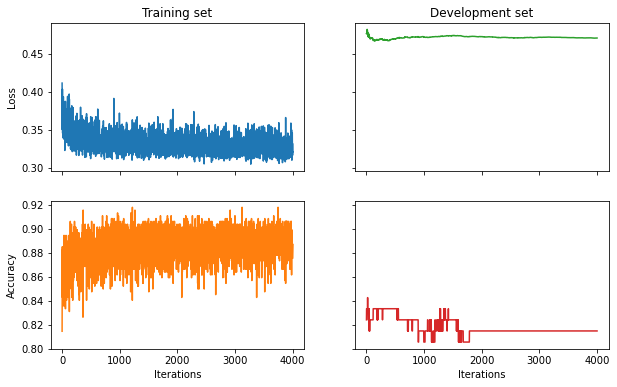

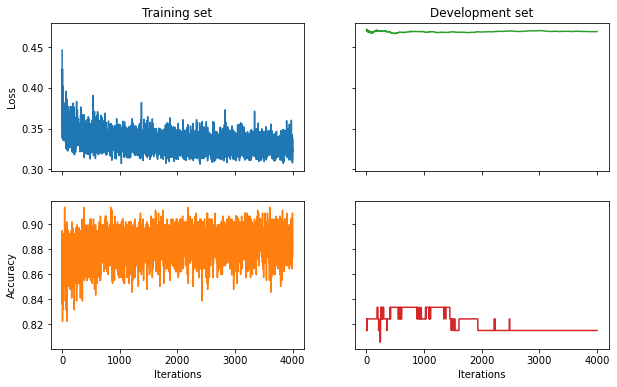

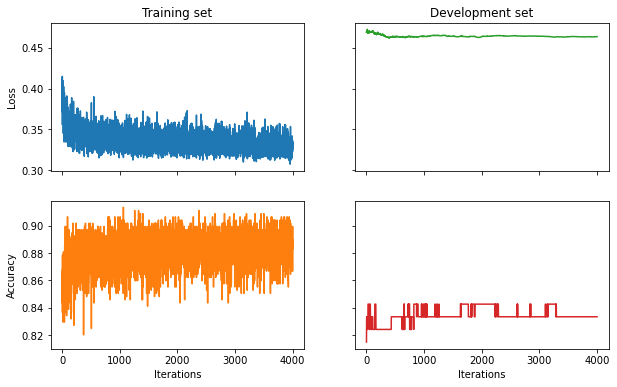

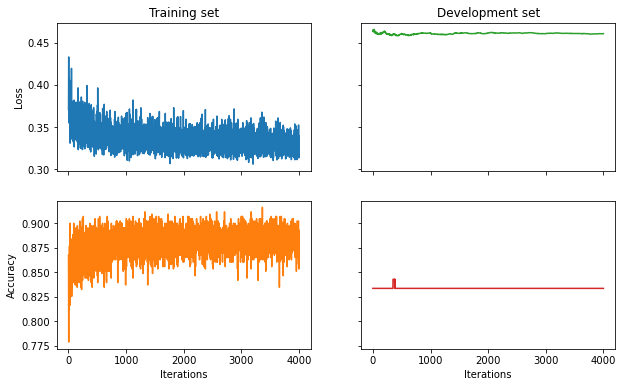

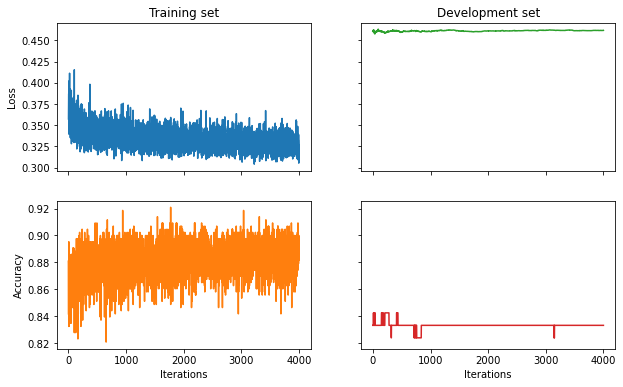

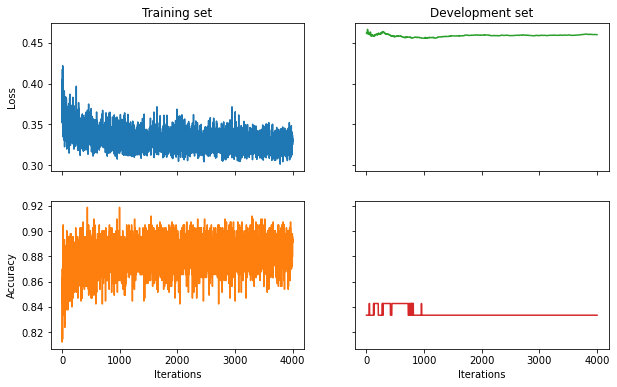

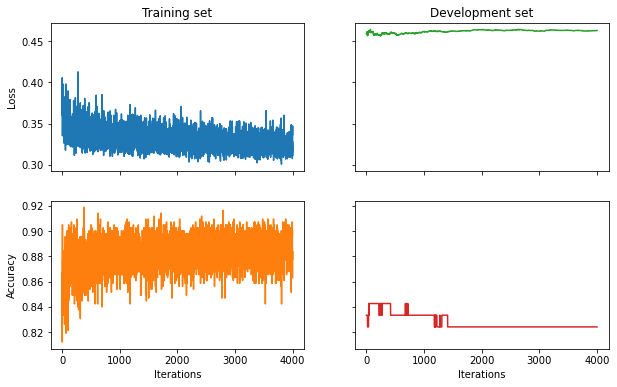

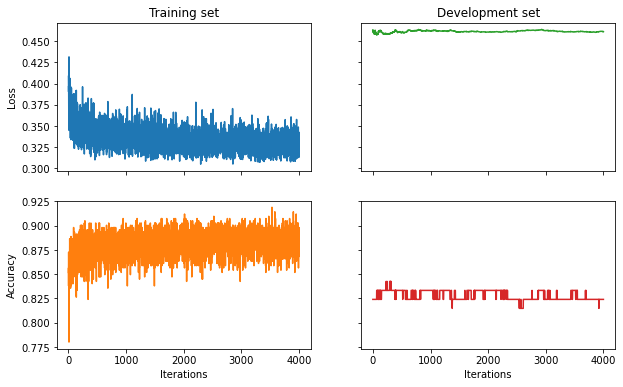

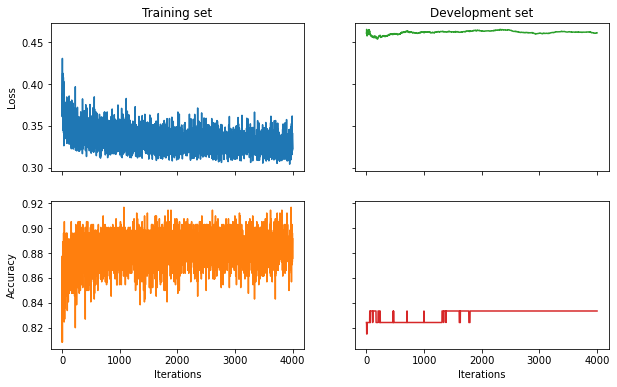

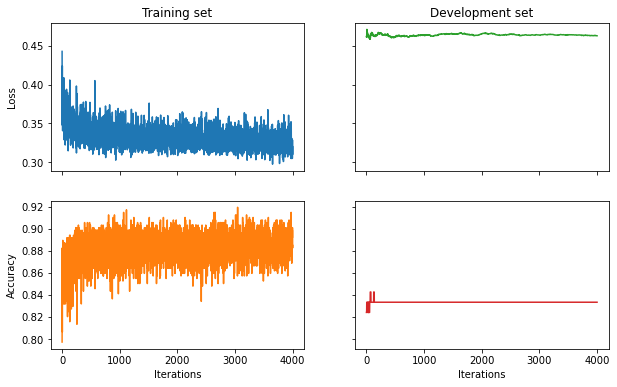

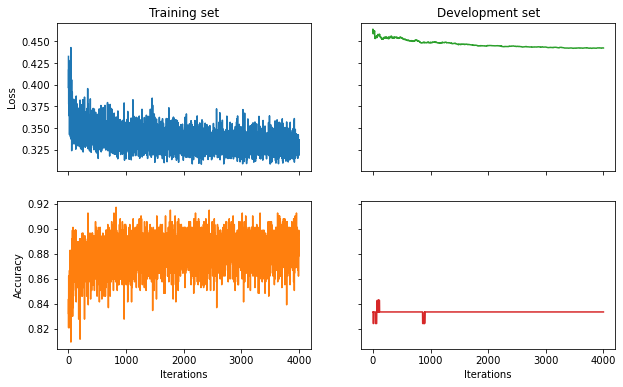

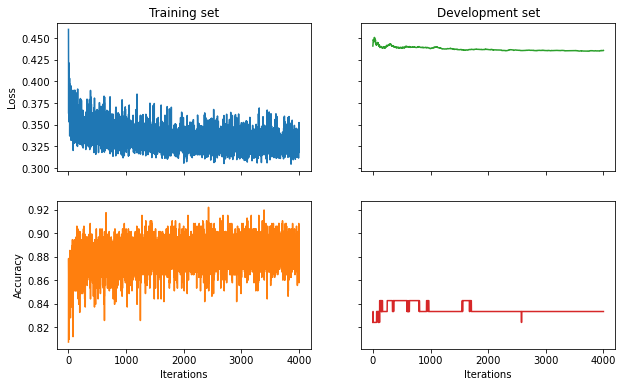

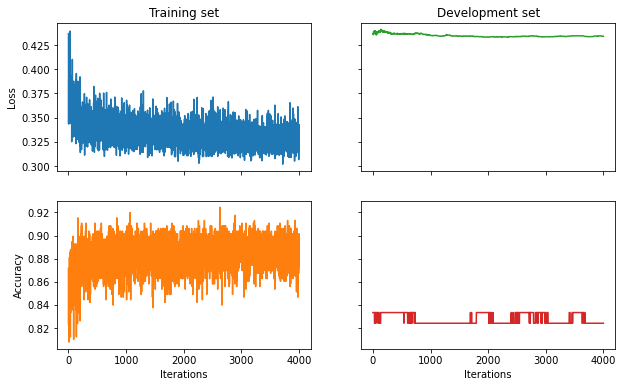

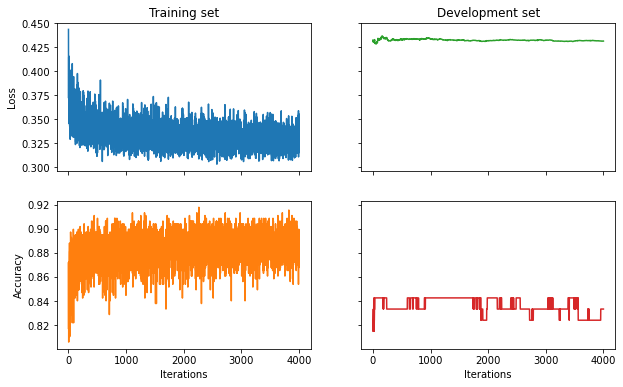

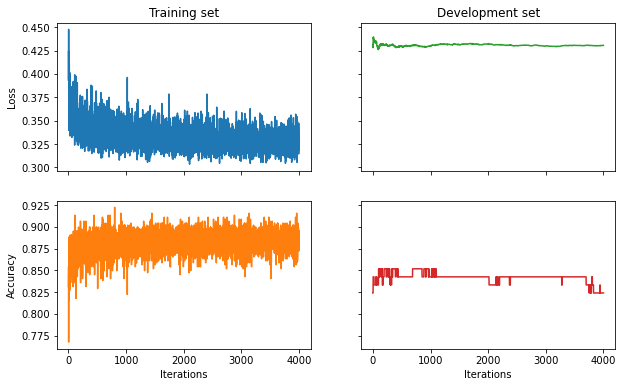

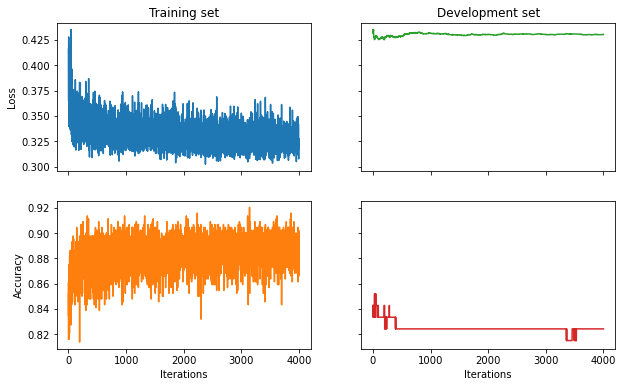

In [9]:
for i, key in enumerate(all_training_keys[initial_number_of_circuits:]):
    print("Progress: ", round((i + initial_number_of_circuits)/len(all_training_keys), 3))
    
    if len(syms) == len(get_symbols(current_training_circuits)) and i > 0:
        if i != len(all_training_keys[1:]):
            current_training_circuits[key] = training_circuits[key]
            new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
            if result:
                parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)
                #continue
            else:
                syms = get_symbols(current_training_circuits)
                parameters = sorted(syms, key=default_sort_key)
                init_params_spsa = np.array(rng.random(len(parameters)))
    else:
        run += 1
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    if len(current_validation_circuits) == 0 or len(current_test_circuits) == 0:
        continue
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    # Limit the number of validation and test circuits to 20% of number of the training circuits
    if limit:
        val_test_circ_size = ceil(len(current_training_circuits))
        if len(current_validation_circuits) > val_test_circ_size:
            validation_circuits_l = validation_circuits_l[:val_test_circ_size]
            validation_data_labels_l = validation_data_labels_l[:val_test_circ_size]
        if len(current_test_circuits) > val_test_circ_size:
            test_circuits_l = test_circuits_l[:val_test_circ_size]
            test_data_labels_l = test_data_labels_l[:val_test_circ_size]
    
    stats = f"Number of training circuits: {len(training_circuits_l)}   "\
        + f"Number of validation circuits: {len(validation_circuits_l)}   "\
        + f"Number of test circuits: {len(test_circuits_l)}   "\
        + f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}"
    
    with open("results//" + result_file + ".txt", "a") as f:
        f.write(stats + "\n")
    
    print(stats)
    
    train_pred_fn = jit(make_pred_fn(training_circuits_l))
    dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
    test_pred_fn = make_pred_fn(test_circuits_l)
    
    train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
    dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)
    
    def callback_fn(xk):
        #print(xk)
        valid_loss = dev_cost_fn(xk)
        train_loss = numpy.around(min(float(train_costs[-1]), float(train_costs[-2])), 4)
        train_acc = numpy.around(min(float(train_accs[-1]), float(train_accs[-2])), 4)
        valid_acc = numpy.around(float(dev_accs[-1]), 4)
        iters = int(len(train_accs)/2)
        if iters % 200 == 0:
            info = f"Epoch: {iters}   "\
            + f"train/loss: {train_loss}   "\
            + f"valid/loss: {numpy.around(float(valid_loss), 4)}   "\
            + f"train/acc: {train_acc}   "\
            + f"valid/acc: {valid_acc}"
        
            with open("results//" + result_file + ".txt", "a") as f:
                f.write(info + "\n")
                
            print(info, file=sys.stderr)
        return valid_loss
    
    a_value = 0.0053
    c_value = 0.0185
            
    train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
    dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)

    result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = a_value, c = c_value, niter=EPOCHS, callback=callback_fn)
    #result = minimizeCompass(train_cost_fn, x0=init_params_spsa, redfactor=2.0, deltainit=1.0, deltatol=0.001, feps=1e-15, errorcontrol=True, funcNinit=30, funcmultfactor=2.0, paired=True, alpha=0.05, callback=callback_fn)

    figure_path = this_folder + "//results//" + result_file + ".png"
    visualize_result_noisyopt(result, make_cost_fn, test_pred_fn, test_data_labels_l, train_costs, train_accs, dev_costs, dev_accs, figure_path, result_file)
    
    run += 1
    #EPOCHS += 100
    syms = get_symbols(current_training_circuits)
    
    # Extend for the next optimization round
    current_training_circuits[key] = training_circuits[key]
    new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
    parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)